```{image} ../images/ENSOblog_animation_SSTA_anom_weekly_2023_Jun.gif
:width: 100%
:align: center
```

# El Niño - Oscilación del Sur (ENOS)

---

## Introducción
En este cuadernillo (Notebook) aprenderemos:

1. Breve introducción al fenómeno ENOS.
1. Acceso a datos públicos de la NOAA.
1. Generación de mapas con anomalías de temperatura superficial del Océano Pacífico Tropical.
1. Reproducción de la gráfica del índice ONI en la región Niño 3.4

## 📚 Descripción general

En este cuaderno explorarás el fenómeno El Niño-Oscilación del Sur (ENOS), uno de los patrones climáticos más importantes que afecta el clima global y regional. Aprenderás a acceder y procesar datos de temperatura superficial del mar (TSM) de NOAA para identificar eventos El Niño y La Niña mediante el cálculo del índice ONI (Oceanic Niño Index) en la región Niño 3.4.

Utilizarás técnicas de análisis climático estándar como el cálculo de climatologías, anomalías, y ponderación por latitud. Al final, reproducirás gráficas operacionales similares a las que usa NOAA para monitorear el estado actual de ENOS, una habilidad fundamental para estudios de variabilidad climática y predicción estacional.

## ✅ Requisitos previos

| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario |  Manejo de datos multidimensionales espacializados|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necesario |  Generación de gráficas|
| [Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necesario |  Generación de mapas|
| [NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Familiaridad con la estructura de datos y metadatos. |


⏱️ **Tiempo estimado de aprendizaje**: 30 minutos

✍️ **Formato**: Interactivo

---

## 1. El Niño/La Niña

Para entender los eventos El Niño o La Niña debemos, primero, introducir que es ENOS. De acuerdo con la Organización Meteorológica Mundial (WMO por sus siglas en inglés de *World Meteorological Organization*) podemos decir que:

>*El Niño/Oscilación del Sur (ENOS) es un fenómeno natural caracterizado por la fluctuación de las temperaturas del océano en la parte central y oriental del Pacífico ecuatorial, asociada a cambios en la atmósfera. Este fenómeno tiene una gran influencia en las condiciones climáticas de diversas partes del mundo.*

Actualmente es de gran interés en nuestra comunidad científica entender y predecir los efectos de corto y largo alcance de estas fluctuaciones, pues estas suelen estar asociadas a fuertes lluvias o sequías en algunas partes del mundo. 

Se dice que, cuando ENOS está en su fase cálida hay un evento **El Niño**, mientras que, su fase fría se denomina **La Niña**.

### 1.1 ¿Cómo saber si hay un evento El Niño o La Niña?

Durante los episodios **El Niño**, la temperatura de la superficie del mar (TSM) en las partes central y oriental del Pacífico Tropical suele ser muy superior a la normal, mientras que, en esas mismas regiones, durante los episodios de **La Niña** la temperatura es inferior a la normal. Para decir que, efectivamente hay un evento del uno o del otro, se utilizan índices Oceánicos de medición de ENOS que cuantifican el estado de la anomalía de TSM. 

Por ejemplo, en la figura se pueden ver varias regiones de cálculo de la anomalía. Nosotros nos concentraremos en la región **Niño 3.4** a lo largo de este taller, la cual se define como la región entre +/- 5° latitud y 170° W, 120° W longitud.

<img src="../images/nino-regions.gif" width=500 alt="ENSO"></img>

Las fases cálidas o frías del Índice del Niño Oceánico (ONI) se definen por cinco anomalías medias consecutivas de TSM durante cinco meses consecutivos en la región elegida -en nuestro caso Niño 3.4-  que están por encima del umbral de +0,5 °C (cálido), o por debajo del umbral de -0,5°C (frío). Las oscilaciones de episodios ENOS pueden presentarse en intervalos que varían entre 2 y 7 años.

---

## Librerías

Importamos las librerías que usaremos a lo largo de este cuadernillo.

In [1]:
import cartopy.crs as ccrs
import hvplot.xarray  # noqa
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
# Configuración de Dask para procesamiento paralelo (opcional)
# Esto acelera el cálculo de climatologías con datos grandes
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=4,           # Número de procesos paralelos
    memory_limit='2GB'     # Límite de memoria por worker
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34485/status,
Dashboard: http://127.0.0.1:34485/status,Workers: 4
Total threads: 12,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43553,Workers: 0
Dashboard: http://127.0.0.1:34485/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37333,Total threads: 3
Dashboard: http://127.0.0.1:38681/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:38587,


## 2. Acceso a los datos de  temperatura de la [NOAA ERSST](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html)

Usaremos los datos de temperaturas superficiales del mar de la Oficina Nacional de Administración Océanica y Atmosférica de Estados Unidos (NOAA por sus siglas en inglés).

In [3]:
# Cargar datos de temperatura superficial del mar (NOAA ERSST v5)
url = '../data/sst.mnmean.nc'
ds = xr.open_dataset(
    url,
    engine='netcdf4',
    chunks={'time': 120}  # Chunks grandes para soportar rolling window de 3 meses
)

In [4]:
ds

<xarray.Dataset> Size: 132MB
Dimensions:    (time: 2061, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-09-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB dask.array<chunksize=(60, 2), meta=np.ndarray>
    sst        (time, lat, lon) float32 132MB dask.array<chunksize=(60, 89, 180), meta=np.ndarray>
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2025-10-03

In [5]:
ds

<xarray.Dataset> Size: 132MB
Dimensions:    (time: 2061, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-09-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 33kB dask.array<chunksize=(60, 2), meta=np.ndarray>
    sst        (time, lat, lon) float32 132MB dask.array<chunksize=(60, 89, 180), meta=np.ndarray>
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2025-10-03

```{note}
**Fuente de datos**: Usamos un archivo local del conjunto de datos NOAA ERSST v5.

Alternativamente, puedes acceder directamente al servidor THREDDS de NOAA (requiere conexión estable):
```python
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, engine='netcdf4')
```
```

Hagamos algunas visualizaciones básicas de los datos, solo para asegurarnos de que parezcan razonables.

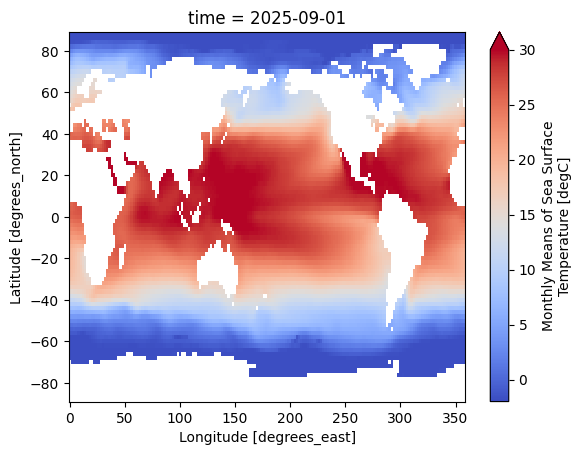

In [6]:
ds.sst[-1].plot(vmin=-2, vmax=30, cmap="coolwarm", robust=True);

Podemos usar `Cartopy` para "embellecer" el gráfico

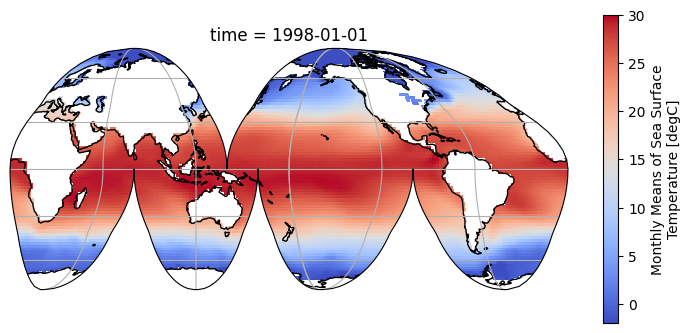

In [7]:
# Definir el tamaño de la figura
fig = plt.figure(figsize=(9, 4))

# Asignar un eje y projección del mapa
ax = plt.axes(
    projection=ccrs.InterruptedGoodeHomolosine(central_longitude=180, globe=None)
)

# Agregar líneas costeras
ax.coastlines()

# Agregar las líneas de retícula (lon and lat)
ax.gridlines()
ds.sst.sel(time="1998-01").plot(
    vmin=-2, vmax=30, cmap="coolwarm", transform=ccrs.PlateCarree()
)

## 3. Anomalías de temperatura superficial del Océano Pacífico Tropical

“Anomalía” significa que se ha eliminado el ciclo estacional, también llamado “climatología”.


### 3.1 Climatología
Para estimar la climatología podemos usar la funcionalidad de `xarray` denominada `groupby` donde agrupamos por meses del año y luego tomamos la media a lo largo de cada mes usando el metodo `mean`

In [8]:
%%time
sst_clim = ds.sst.groupby("time.month").mean("time", skipna=True)

CPU times: user 46 ms, sys: 2.06 ms, total: 48.1 ms
Wall time: 56.9 ms


Ahora podemos visualizar la climatología media zonal

CPU times: user 359 ms, sys: 38.9 ms, total: 398 ms
Wall time: 1.82 s


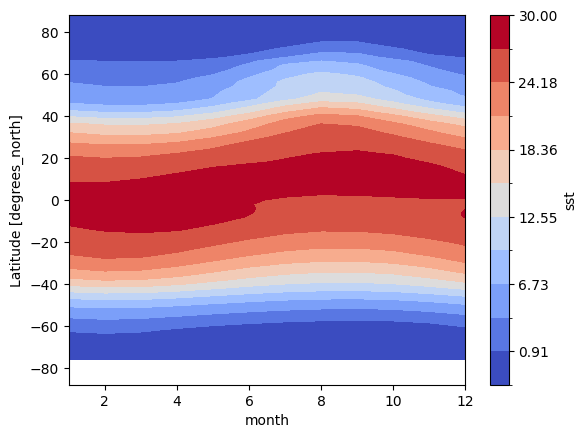

In [9]:
%%time
sst_clim.mean(dim="lon").transpose().plot.contourf(
    levels=12, vmin=-2, vmax=30, cmap="coolwarm"
);

### 3.2 Cálculo de la anomalía
La anomalía esta dada por el valor de la TSM - SST (por sus siglas en inglés) media para cada mes

In [10]:
sst_anom = ds.sst.groupby("time.month") - sst_clim

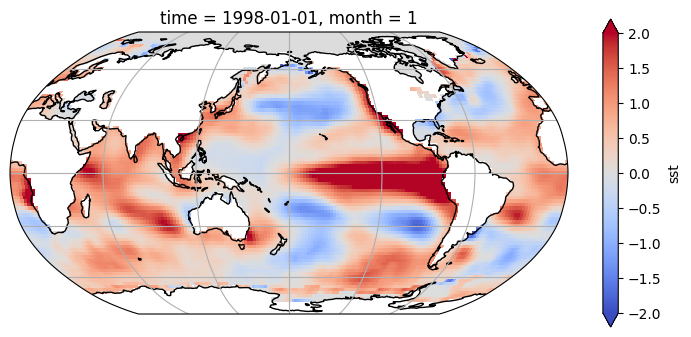

In [11]:
# Definir el tamaño de la figura
fig = plt.figure(figsize=(9, 4))

# Asignar un eje y proyección del mapa
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# Añadir líneas costeras
ax.coastlines()

# Añadir líneas de la cuadrícula (longitud y latitud)
ax.gridlines()
sst_anom.sel(time="1998-01").plot(
    vmin=-2, vmax=2, cmap="coolwarm", transform=ccrs.PlateCarree()
);

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Cuidado</p>
    Debemos ponderar la anomalía con respecto a su posición en latitud
</div>


<img src="../images/t6_area_average.png" width=600 alt="ENSO"></img>


**¿Por qué necesitamos ponderar nuestros datos?**

Las celdas de la cuadrícula más cercanas al ecuador son mucho más grandes que las cercanas a los polos, como se ve en la figura anterior (Djexplo, 2011, CC-BY)

In [12]:
weights = np.cos(np.deg2rad(ds.lat)).where(~sst_anom[0].isnull())
weights /= weights.mean()

In [13]:
sst_anom_wgt = sst_anom * weights

Veamos cómo se ve el promedio global vs el promedio ponderado de la anomalía de la temperatura superficial del océano usando ahora [`hvplot`](https://hvplot.holoviz.org/index.html)

In [14]:
# Promedio global de la anomalía
gb_anom = sst_anom.mean(dim=["lon", "lat"])
_anom = gb_anom.hvplot.line(x="time", y="sst", label="Inicial")

# Promedio global de la anomalía ponderada
gb_anom_wtd = sst_anom_wgt.mean(dim=["lon", "lat"])
gb_anom_wtd.name = "sst"
_anom_wtg = gb_anom_wtd.hvplot.line(x="time", label="Ponderado")
# _anom_wtg
_anom * _anom_wtg

:Overlay
   .Curve.Inicial   :Curve   [time]   (sst)
   .Curve.Ponderado :Curve   [time]   (sst)

Esta gráfica parece tener una tendencia. El incremento en la temperatura superficial del mar se puede observar después de ~1950 (¿CC?). Ahora debemos remover la **tendencia**

In [15]:
from scipy.signal import detrend

sst_anom_wgt_dtd = xr.apply_ufunc(
    detrend, sst_anom_wgt.fillna(0).load(), kwargs={"axis": 0}
).where(~sst_anom.isnull())
sst_anom_wgt_dtd.name = "sst"

In [16]:
# Promedio global de la anomalía ponderada sin tendencia
gb_anom_wtd_dtd = sst_anom_wgt_dtd.mean(dim=["lon", "lat"])
_anom_wtd_dtd = sst_anom_wgt_dtd.mean(dim=["lon", "lat"]).hvplot.line(
    x="time", y="sst", label="Ponderado sin tendencia"
)
_anom * _anom_wtg * _anom_wtd_dtd

:Overlay
   .Curve.Inicial                 :Curve   [time]   (sst)
   .Curve.Ponderado               :Curve   [time]   (sst)
   .Curve.Ponderado_sin_tendencia :Curve   [time]   (sst)

Miremos ahora la anomalía de la SST para enero de 1998

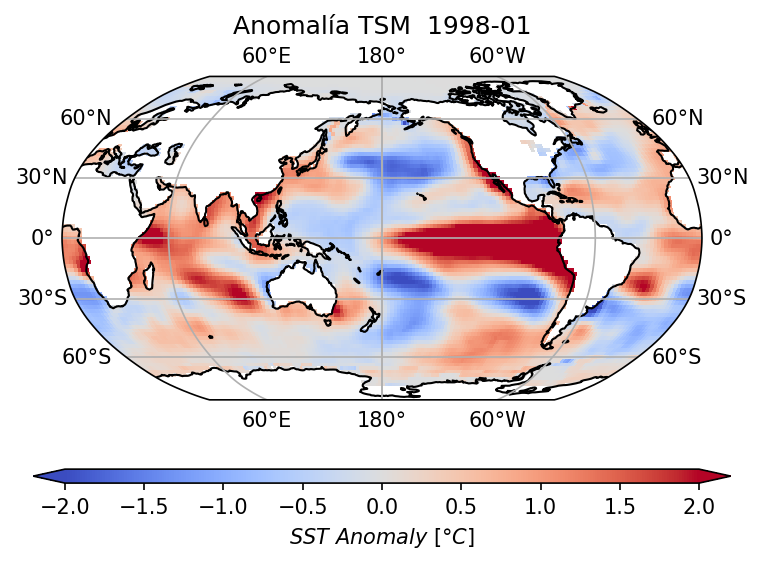

In [17]:
fig, ax = plt.subplots(
    figsize=(6, 4),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
    dpi=150,
)
sst_anom_wgt_dtd.sel(time="1998-01").plot(
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "label": r"$SST \ Anomaly \ [°C]$",
        "orientation": "horizontal",
        "aspect": 50,
    },
)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.xlocator = mticker.FixedLocator([-180, -60, 60, 180])
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
plt.title(
    f"Anomalía TSM {pd.to_datetime(sst_anom_wgt_dtd.sel(time='1998-01').time[0].values): %Y-%m}"
);

Veamos qué pasa si cambiamos la proyección del mapa

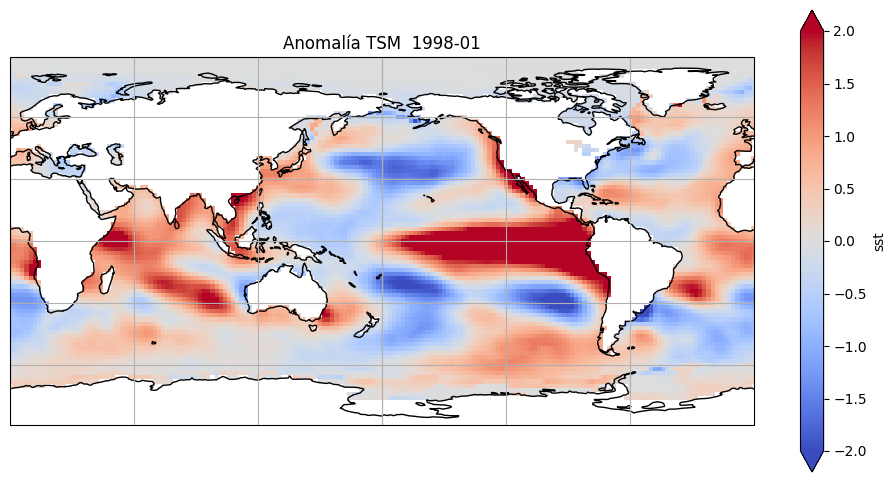

In [18]:
# Definir el tamaño de la figura
fig = plt.figure(figsize=(12, 6))

# Asignar un eje y proyección del mapa
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Añadir líneas costeras
ax.coastlines()

# Añadir líneas de cuadricula (lon y lat)
ax.gridlines()
sst_anom_wgt_dtd.sel(time="1998-01").plot(
    vmin=-2, vmax=2, cmap="coolwarm", transform=ccrs.PlateCarree()
)
plt.title(
    f"Anomalía TSM {pd.to_datetime(sst_anom_wgt_dtd.sel(time='1998-01').time[0].values): %Y-%m}"
);

### 3.3 Tratemos de reproducir la gráfica de la NOAA

Tratemos de usar nuestros datos para generar una gráfica como esta:

<img src="../images/nino_2023_agosto.JPG" width=800 alt="ENSO"></img>

In [19]:
sst_anom_sub = sst_anom_wgt_dtd.sel(lat=slice(60, -60), lon=slice(25, 360))

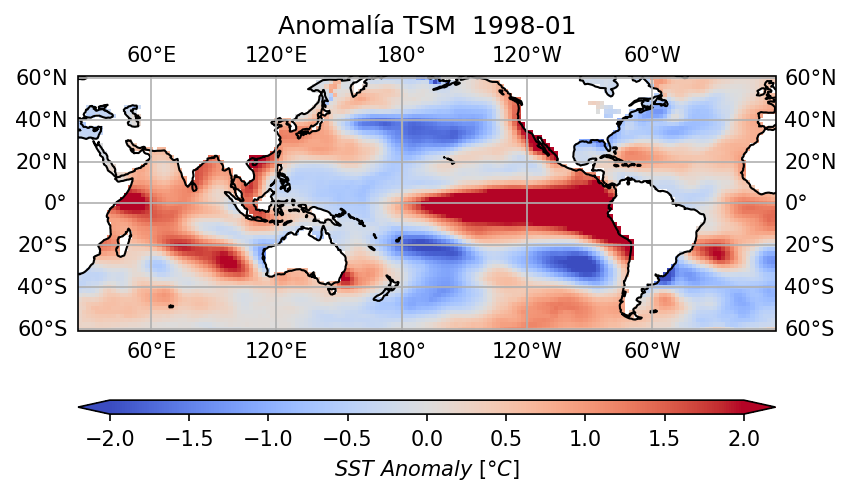

In [20]:
fig, ax = plt.subplots(
    figsize=(6, 4),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
    dpi=150,
)
sst_anom_sub.sel(time="1998-01").plot(
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "label": r"$SST \ Anomaly \ [°C]$",
        "orientation": "horizontal",
        "aspect": 50,
    },
)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
plt.title(
    f"Anomalía TSM {pd.to_datetime(sst_anom_wgt_dtd.sel(time='1998-01').time[0].values): %Y-%m}"
);

## 4. Índice ONI en la región Niño 3.4

<img src="../images/eln-f-pg.gif" width=600 alt="ENSO"></img>

La región Niño 3.4 se define como la región entre +/- 5 grados. latitud, 170 W - 120 W longitud.


In [21]:
nino_34 = sst_anom_wgt_dtd.sel(
    lat=slice(5, -5), lon=slice(180 - (180 - 170), 180 + (180 - 120))
)

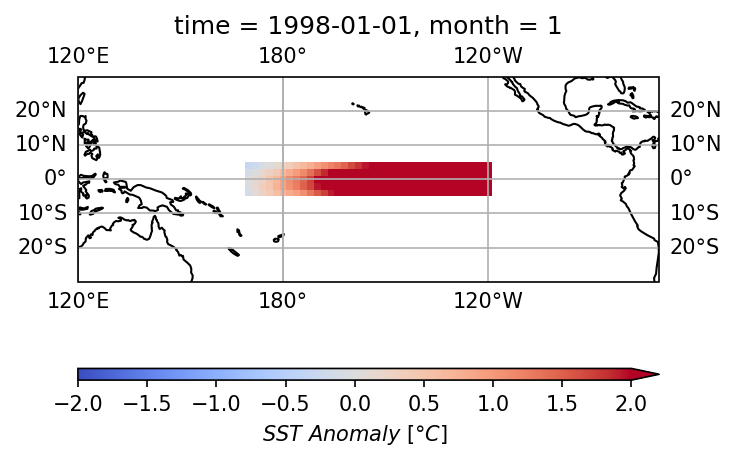

In [22]:
fig, ax = plt.subplots(
    figsize=(5, 5),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
    dpi=150,
)
nino_34.sel(time="1998-01").plot(
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "label": r"$SST \ Anomaly \ [°C]$",
        "orientation": "horizontal",
        "aspect": 50,
    },
)
ax.coastlines()
ax.set_extent([120, 290, -30, 30], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree());

Ahora podemos generar nuestro índice ONI con una ventana móvil de 3 meses

In [26]:
# Calcular índice ONI con ventana móvil de 3 meses
# Agregamos .compute() para evitar problemas con chunks pequeños
oni = nino_34.mean(['lat', 'lon']).compute().rolling(time=3, center=True).mean()

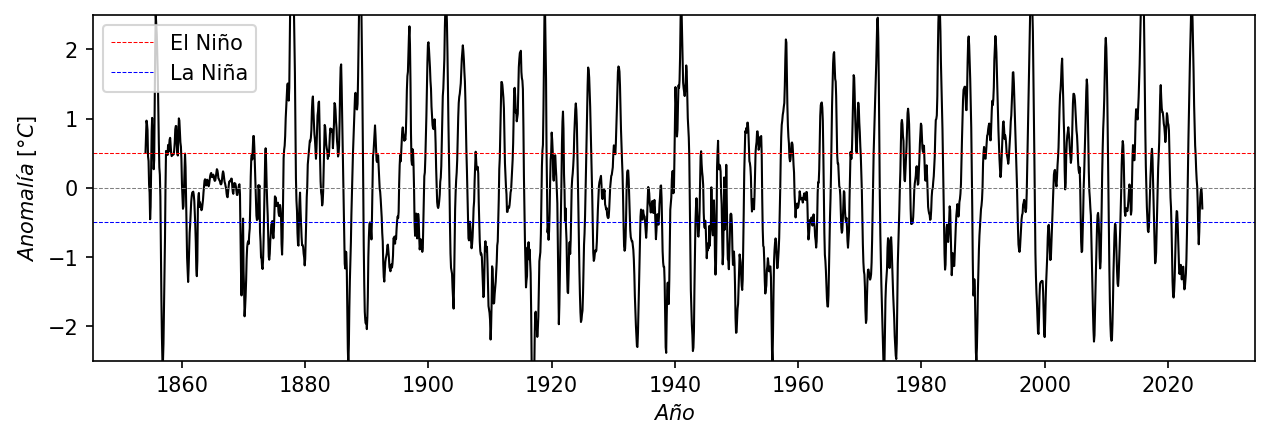

In [27]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(oni.time, oni, lw=1, c="k")
ax.axhline(0, c="grey", lw=0.5, ls="--")
ax.axhline(0.5, c="r", lw=0.5, ls="--", label="El Niño")
ax.axhline(-0.5, c="b", lw=0.5, ls="--", label="La Niña")
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel("$Año$")
ax.set_ylabel(r"$Anomalía \ [°C]$")
ax.legend();

Podemos seleccionar los últimos **70 años** para efectos de visualización

In [28]:
oni_sub = oni.sel(time=slice("1950", "2023"))

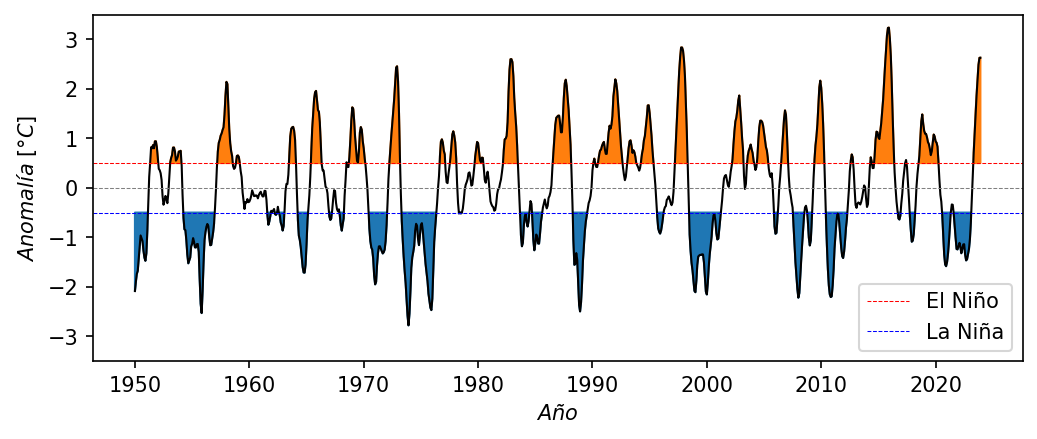

In [29]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
ax.plot(oni_sub.time, oni_sub, lw=1, c="k")
ax.axhline(0, c="grey", lw=0.5, ls="--")
ax.axhline(0.5, c="r", lw=0.5, ls="--", label="El Niño")
ax.axhline(-0.5, c="b", lw=0.5, ls="--", label="La Niña")
ax.fill_between(oni_sub.time, 0.5, oni_sub.where(oni_sub >= 0.5), color="C01")
ax.fill_between(oni_sub.time, -0.5, oni_sub.where(oni_sub <= -0.5), color="C00")

ax.set_ylim(-3.5, 3.5)
ax.set_xlabel("$Año$")
ax.set_ylabel(r"$Anomalía \ [°C]$")
ax.legend()
plt.show()

---

## Actividades Prácticas

### 🏋️ Práctica: Identificando eventos ENOS

Usa el gráfico del índice ONI para responder:

1. ¿Cuántos eventos El Niño (ONI > 0.5°C) observas en el período 1950-2023?
2. ¿Cuál fue el evento El Niño más intenso? ¿En qué año ocurrió?
3. Identifica un evento La Niña reciente (después de 2010)

**Pistas**:
- El Niño: Barras rojas que superan +0.5°C
- La Niña: Barras azules que caen bajo -0.5°C
- Un evento requiere al menos 5 meses consecutivos sobre el umbral

````{admonition} Solución
:class: dropdown

1. **Eventos El Niño (1950-2023)**: Aproximadamente 15-18 eventos
   - Criterio: ONI > +0.5°C por 5+ meses consecutivos

2. **El Niño más intenso**: 1997-1998
   - Pico ONI: ~2.3°C
   - Duración: ~1 año
   - Impactos globales severos

3. **La Niña reciente**: 2020-2023
   - Evento triple-dip (3 años consecutivos)
   - ONI llegó a ~-1.3°C

**Nota**: Los eventos varían en intensidad, duración y patrones espaciales. El índice ONI es solo una medida promedio de la región Niño 3.4.
````

## Resumen

En este cuadernillo brevemente describimos el fenómeno ENOS y sus fases cálida (El Niño) y fría (La Niña). Aprendimos a:

✅ **Acceder a datos de TSM** desde servidores OPENDAP de NOAA

✅ **Calcular climatologías y anomalías** de temperatura superficial del mar

✅ **Aplicar correcciones** (ponderación por latitud, remoción de tendencia)

✅ **Calcular el índice ONI** para identificar eventos El Niño y La Niña

✅ **Reproducir gráficas operacionales** similares a las de NOAA

```{tip}
Estas técnicas son fundamentales para análisis climático y pueden aplicarse a otros fenómenos oceánico-atmosféricos.
```

### ¿Qué sigue?

Con estos conocimientos sobre ENOS, puedes explorar:

- **[3.3. Datos de reanálisis ERA5]** - Análisis de patrones atmosféricos durante eventos ENSO
- **[2.1. Datos de estaciones]** - Validar impactos de ENSO en precipitación local
- **Pronóstico estacional** - Usar índices ENSO para predicción climática

### Proyecto sugerido:

Analiza cómo ENSO afecta la precipitación en Colombia:
1. Descarga datos de estaciones del IDEAM durante eventos El Niño y La Niña
2. Compara anomalías de precipitación con el índice ONI
3. Identifica patrones regionales (Pacífico vs Caribe vs Andino)

## Recursos y Referencias
